In [ ]:
# installing dependencies
!pip install einops
!pip install mlflow

In [ ]:
# importing modules
import mlflow
from mlflow import MlflowClient
import matplotlib.pyplot as plt
import numpy as np
import einops
import math
from tqdm.notebook import tqdm, trange
from torchsummary import summary
import torch.nn.functional as F
import time
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop
import torchvision.transforms as transforms

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'     # choosong device

In [ ]:
# defining  ViT model specific parameters
DATASET='Cifar10 '

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 5,
    "num_attention_heads": 12,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# defining dataset/training specific parameters
base_lr = 5e-4
weight_decay = 1e-6
num_classes = 10
accum_iter = 4
tasks = 5
epochs = 5
batch_size = 32

In [ ]:
# hyperparameters specific to BiRT training
alpha_t = 0.05   # controls amount of label noise
alpha_a = 0.05   # controls amount of attention noise
alpha_s = 0.05   # controls amount of trial to trial variability, by applying noise to logits of semantic memory
alpha_e = 0.003   # controls updation of sematic weights
alpha_loss_rep = 0.4  # hyperparameter used in representation loss
rho_loss_cr = 1       # hyperparameter used in calculating total loss
beta_1_loss = 0.05     # hyperparameter used in consistency regulation loss
beta_2_loss = 0.01     # hyperparameter used in consistency regulation loss
_gamma = 0.005          # hyperparameter used for updating semantic memory
percentage_change = 15  # hyperparameter used in label noise
std = 1                 # hyperparameter for normal distribution used in creating noise to be appliedsemntic memory logits
mean = 0                # hyperparameter for normal distribution used in creating noise to be appliedsemntic memory logits
c = 0             # value of 1 enables attention noise, 0 disables it

In [ ]:
# define transforms on dataset
transform_training_data = Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# define path to training dataset
train_data = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/ViT_CIFAR10_data', train=True, download=True, transform=transform_training_data)


# create a dictionary to store the class indices
class_indices  = {i: [] for i in range(num_classes)}

# seperate indices with respect to classes
for i in range(int(len(train_data))):
    current_class = train_data[i][1]
    class_indices[current_class].append(i)




Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# make datasets for each tasks
task_list = []

for index in range(tasks):
    class_indices_for_task = sum([class_indices[i][0:1000] for i in range((index * num_classes) // tasks, ((index + 1) * num_classes) // tasks)], [])
    print(len(class_indices_for_task))
    print(class_indices_for_task[0:10])
    print(class_indices_for_task[len(class_indices_for_task)-10:len(class_indices_for_task)])

    sub_dataset = torch.utils.data.Subset(train_data, class_indices_for_task)
    trainloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
    task_list.append(trainloader)
print(len(task_list))


2000
[29, 30, 35, 49, 77, 93, 115, 116, 129, 165]
[10153, 10157, 10168, 10169, 10188, 10190, 10229, 10236, 10248, 10249]
2000
[6, 13, 18, 24, 41, 42, 47, 48, 54, 55]
[9794, 9817, 9830, 9841, 9842, 9846, 9856, 9865, 9892, 9897]
2000
[3, 10, 20, 28, 34, 58, 66, 82, 86, 89]
[10657, 10668, 10669, 10670, 10691, 10692, 10696, 10703, 10709, 10710]
2000
[0, 19, 22, 23, 25, 72, 95, 103, 104, 117]
[9834, 9836, 9851, 9891, 9906, 9939, 9956, 9957, 9958, 9964]
2000
[8, 62, 69, 92, 100, 106, 111, 135, 139, 155]
[10123, 10129, 10138, 10144, 10149, 10161, 10163, 10178, 10187, 10198]
5


In [ ]:
# defining transforms on test data
transform_test_data = Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# defining path to test data
test_data = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/ViT_CIFAR10_data', train=False, download=True, transform=transform_test_data)

# defining dataloader for test data
ten_percent_test = int(len(test_data))
subset_test_data = torch.utils.data.Subset(test_data, range(ten_percent_test))
testloader = torch.utils.data.DataLoader(subset_test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2, drop_last = True)

Files already downloaded and verified


torch.Size([32, 3, 32, 32])
torch.Size([32])


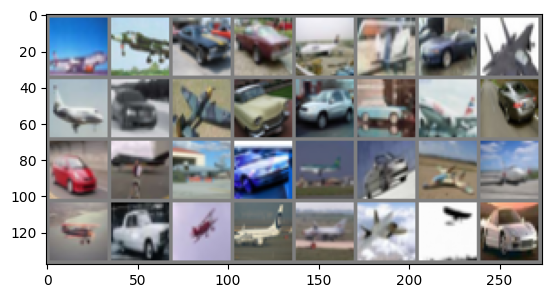

0     0     1     1     0     0     1     0     0     1     0     1     1     1     0     1     1     0     0     1     0     1     0     0     0     1     0     0     0     0     0     1    


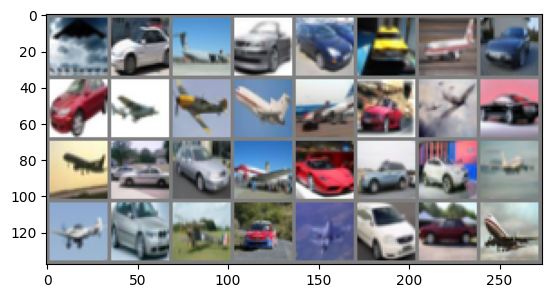

0     1     0     1     1     1     0     1     1     0     0     0     0     1     0     1     0     1     1     0     1     1     1     0     0     1     0     1     0     1     1     0    
<class 'torch.Tensor'>


In [ ]:
# functions to visualize an image
def imshow2(img):
  img = img / 5 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# plotting 2 batches of the first task
dataiter = iter(task_list[0])
images1, labels1 = next(dataiter)
images2,labels2 = next(dataiter)
print(images1.size())
print(labels1.size())

imshow(torchvision.utils.make_grid(images1))
print(' '.join(f'{labels1[j]:<5}' for j in range(batch_size)))
imshow(torchvision.utils.make_grid(images2))
print(' '.join(f'{labels2[j]:<5}' for j in range(batch_size)))
print(type(labels2[0]))

In [ ]:
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x,c):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        if(c==1):
            attention_probs = attention_probs + torch.randn(attention_probs.size()).to(device)*std + mean
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, c,output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x,c) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x,c, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        if(c==1):
            attention_probs = attention_probs + torch.randn(attention_probs.size()).to(device)*std + mean
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, c,output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x),c, output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self,config, num_encoders):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(num_encoders):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x,c, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, c,output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        self.num_encoders = config["num_hidden_layers"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config, self.num_encoders)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x,c, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output,c, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

class ViTForClassfication_g(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.num_encoders = 2
        self.encoder = Encoder(config, self.num_encoders)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x,c, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output,c, output_attentions=output_attentions)

        if not output_attentions:
            return (encoder_output, None)
        else:
            return (encoder_output, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

class ViTForClassfication_f(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.num_encoders = 2
        self.encoder = Encoder(config, self.num_encoders)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x,c, output_attentions=False):
        # Calculate the embedding output

        encoder_output, all_attentions = self.encoder(x, c,output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)



In [ ]:
# creating model instances for training and defining optimizer and loss function
model_g = ViTForClassfication_g(config).to(device)
model_f_w = ViTForClassfication_f(config).to(device)
model_f_s = ViTForClassfication_f(config).to(device)
optimizer = optim.Adam(list(model_g.parameters()) + list(model_f_w.parameters()), lr=base_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
def select_exemplars(X, m):
    """
    Incremental exemplar selection algorithm.

    Parameters:
    - X: Set of input images as PyTorch tensors.
    - m: Target number of exemplars.

    Returns:
    - P: Set of exemplars as PyTorch tensors.
    """
    # Initialize the class mean
    print(len(X))
    mu = torch.mean(torch.stack(X), dim=0)
    print(mu.shape)

    # Initialize the exemplar set
    P = []

    # Exemplar selection loop
    for k in range(1, m+1):
        # Compute distances and select exemplar
        if not P:
            distances = [torch.norm(mu - (1/k) * (x)) for x in X]
        else:
            distances = [torch.norm(mu - (1/k) * ((x) + torch.sum(torch.stack(P), dim=0))) for x in X]

        p_k_index = torch.argmin(torch.stack(distances))
        p_k = X[p_k_index]
        X.pop(p_k_index)

        # Update class mean with the new exemplar
        mu = (mu * (k-1) + p_k) / k

        # Add exemplar to the set
        P.append(p_k)

    # Convert the list of tensors to a single tensor before returning
    print(len(P))
    print(P[0].size())
    return P


In [ ]:
# defining class for episodic memory
class D_buffer:
  def __init__(self, max_length, batch_size, num_classes, tasks):
    self.max_length = max_length
    self.buffer_images = []
    self.buffer_labels = []
    self.current_index = 0
    self.num_elements = 0
    self.batch_size = batch_size
    self.num_classes = num_classes
    self.tasks = tasks
    self.class_seperate_list  = {i: [] for i in range(num_classes)}
    self.class_icarl_list = {}

  # update using icarl herding
  # seperate batches into seperate seperate images and labels list
  # seperate images based on labels
  # implement icarl herding on each labelset
  # take first max_length / (task_num * num_classes / tasks)

  def update(self, task_sem_mem_list,task_num):
    num_needed_per_class = int(self.max_length / (((task_num + 1)*num_classes) / self.tasks))
    self.buffer_images = []
    self.buffer_labels = []
    images_list = [tup[0] for tup in task_sem_mem_list]
    labels_list = [tup[1] for tup in task_sem_mem_list]
    concatenate_images = torch.cat(images_list, dim=0)
    concatenate_labels = torch.cat(labels_list, dim=0)
    single_images_list = torch.split(concatenate_images, 1, dim = 0)
    single_images_list = [tensor.squeeze(dim = 0) for tensor in single_images_list]
    single_labels_list = torch.split(concatenate_labels, 1, dim = 0)
    single_labels_list = [tensor.squeeze(dim = 0).item() for tensor in single_labels_list]
    task_set = set(single_labels_list)
    for i in range(len(single_images_list)):
      self.class_seperate_list[int(single_labels_list[i])].append(single_images_list[i])
    for i in task_set:
      print(f'length of {i}')
      print(len(self.class_seperate_list[int(i)]))
      select_exemplar_length = min(self.max_length, len(self.class_seperate_list[int(i)]))
      self.class_icarl_list[i] = select_exemplars(self.class_seperate_list[int(i)], select_exemplar_length)
      print('done')

    for i in range(num_classes):
      if(i in self.class_icarl_list):
        self.buffer_images.extend(self.class_icarl_list[i][0:num_needed_per_class])
        self.buffer_labels.extend([i]*num_needed_per_class)

    self.num_elements = len(self.buffer_images)
    return


  def get_batch(self):
    batch_images = []
    batch_labels = []
    for i in range(self.batch_size):
      index = np.random.randint(0, self.num_elements)
      batch_images.append(self.buffer_images[index])
      batch_labels.append(torch.tensor(self.buffer_labels[index]))
    images = torch.stack(batch_images, dim = 0)
    labels = torch.stack(batch_labels, dim = 0)
    return images, labels

  def print(self):
    for item in self.buffer_images:
      print(item)

  def is_empty(self):
    return(len(self.buffer_images) == 0)


In [ ]:
# initiaizing episodic memory
sem_mem_length = 500
sem_mem = D_buffer(sem_mem_length,batch_size,num_classes, tasks )

In [ ]:
# training loop of BiRT
for task_index, trainloader in enumerate(tqdm((task_list), desc=f"task in training", leave=False)):
  start = int(time.time()/60) # task training end time

  for epoch in trange(epochs, desc="Training_Epochs"):
    task_sem_mem_list = []
    train_loss = 0.0
    for batch_idx, batch in enumerate(tqdm((trainloader), desc=f"Epoch {epoch + 1} in training", leave=False)):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat_temp, _ = model_g(x,c)                      # get output from g()
      y_hat_temp_copy = y_hat_temp.detach().clone()  # create a detached copy to be processed further

      # store output from g() along with labels in episodic memory
      task_sem_mem_list.append((y_hat_temp_copy, y))

      # contols sampled from a normal distribution to control different noises introduced in BiRT
      alpha_t_comp, alpha_a_comp, alpha_s_comp, alpha_e_comp = np.random.uniform(0,1,4)

      # sampling mini batch from episodic memory
      if (sem_mem.is_empty() == False):
        r, r_y = sem_mem.get_batch()
        r = r.to((device))
        r_y = r_y.to(device)

        # implementing label noise
        if(alpha_t_comp < alpha_t):
          num_change = int(percentage_change / 100 * batch_size)
          indices_change_r_y = torch.randperm(len(y))[:num_change].to(device)
          r_y_changed = torch.randint(0,num_classes,(num_change,)).to(device)
          r_y[indices_change_r_y] = r_y_changed

        # implementing attention noise
        if(alpha_a_comp < alpha_a):
          c = 1

        r_y_working,_ = model_f_w(r,c)
        r_y_semantic,_ = model_f_s(r,c)

        # adding noise to logits of semantic/episodic memory
        if(alpha_s_comp < alpha_s):
          r_y_semantic =  r_y_semantic + torch.rand(r_y_semantic.size()).to(device)*std + mean

      y_hat_temp = y_hat_temp_copy.to(device)
      y_working,_ = model_f_w(y_hat_temp_copy,c)
      y_semantic,_ = model_f_s(y_hat_temp_copy, c)


      # computing loss
      if(task_index == 0):
        loss_representation = criterion(y_working,y)   # representation loss
      else:
        loss_representation = criterion(y_working,y) + alpha_loss_rep*criterion(model_f_w(r, c)[0], r_y)  # loss

      if(task_index == 0):
        loss_consistency_reg = beta_1_loss * torch.norm(y_working - y_semantic, p=2)**2
      else:
        loss_consistency_reg = beta_1_loss * torch.norm(y_working - y_semantic, p=2)**2  + beta_2_loss*torch.norm( r_y_working-r_y_semantic, p = 2)**2  # consistency regulation noise

      loss = loss_representation + rho_loss_cr * loss_consistency_reg   # total loss
      loss = loss/accum_iter
      loss.backward(retain_graph = True)

      if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(trainloader)):
        optimizer.step()
        optimizer.zero_grad()

      # interpolating parameters of epiodic memory at intervals
      if(alpha_e_comp < alpha_e and task_index > 0):
        for params1, params2 in zip(model_f_s.parameters(), model_f_w.parameters()):
          interpolated_params = _gamma * params1.data + (1 - _gamma) * params2.data
          params1.data.copy_(interpolated_params)

      train_loss += loss.detach().cpu().item() /len(trainloader)

    # Printing average loss per epoch
    print(f"Epoch {epoch + 1}/{epochs} loss: {train_loss:.2f}")

  # copying f_w() paramerters to f_s() for first task
  if task_index == 0:
    for params1, params2 in zip(model_f_s.parameters(), model_f_w.parameters()):
      interpolated_params = params2.data
      params1.data.copy_(interpolated_params)

  print(f"Task {task_index + 1}/{len(task_list)} done")
  end = int(time.time()/60) # task training end time
  task_train_time = end - start
  print(f"Task {task_index} done in {task_train_time} mins")
  start = int(time.time()/60)

  sem_mem.update(task_sem_mem_list, task_index)

  end = int(time.time()/60) # task training end time
  mem_update_time = end - start
  #mlflow.log_metric(f"Time taken to update memory after task {task_index}",mem_update_time )

task in training:   0%|          | 0/5 [00:00<?, ?it/s]

Training_Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1/5 loss: 0.57


Epoch 2 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2/5 loss: 0.58


Epoch 3 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3/5 loss: 0.57


Epoch 4 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4/5 loss: 0.57


Epoch 5 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5/5 loss: 0.57
Task 1/5 done
Task 0 done in 1 mins
length of 0
1482
1482
torch.Size([65, 48])
500
torch.Size([65, 48])
done
length of 1
1486
1486
torch.Size([65, 48])
500
torch.Size([65, 48])
done


Training_Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1/5 loss: 0.81


Epoch 2 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2/5 loss: 0.79


Epoch 3 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3/5 loss: 0.80


Epoch 4 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4/5 loss: 0.79


Epoch 5 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5/5 loss: 0.79
Task 2/5 done
Task 1 done in 1 mins
length of 2
1482
1482
torch.Size([65, 48])
500
torch.Size([65, 48])
done
length of 3
1486
1486
torch.Size([65, 48])
500
torch.Size([65, 48])
done


Training_Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1/5 loss: 0.84


Epoch 2 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2/5 loss: 0.82


Epoch 3 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3/5 loss: 0.81


Epoch 4 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4/5 loss: 0.81


Epoch 5 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5/5 loss: 0.82
Task 3/5 done
Task 2 done in 1 mins
length of 4
1486
1486
torch.Size([65, 48])
500
torch.Size([65, 48])
done
length of 5
1482
1482
torch.Size([65, 48])
500
torch.Size([65, 48])
done


Training_Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1/5 loss: 0.82


Epoch 2 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2/5 loss: 0.81


Epoch 3 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3/5 loss: 0.80


Epoch 4 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4/5 loss: 0.81


Epoch 5 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5/5 loss: 0.81
Task 4/5 done
Task 3 done in 1 mins
length of 6
1484
1484
torch.Size([65, 48])
500
torch.Size([65, 48])
done
length of 7
1484
1484
torch.Size([65, 48])
500
torch.Size([65, 48])
done


Training_Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 1/5 loss: 0.81


Epoch 2 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 2/5 loss: 0.81


Epoch 3 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 3/5 loss: 0.81


Epoch 4 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 4/5 loss: 0.79


Epoch 5 in training:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 5/5 loss: 0.80
Task 5/5 done
Task 4 done in 1 mins
length of 8
1486
1486
torch.Size([65, 48])
500
torch.Size([65, 48])
done
length of 9
1482
1482
torch.Size([65, 48])
500
torch.Size([65, 48])
done


In [ ]:
# Test loop
c = 0
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat_temp,_= model_g(x,c)
        y_hat_temp_copy = y_hat_temp.detach().clone()
        y_hat_temp_copy = y_hat_temp.to(device)
        y_hat,_ = model_f_w(y_hat_temp_copy,c)

        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)

    accuracy = correct / total * 100
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {accuracy}%")

Testing:   0%|          | 0/312 [00:00<?, ?it/s]

Test loss: 2.39
Test accuracy: 10.9375%
